In [3]:
!pip install pandas
!pip install scipy
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering


# Objetivo: importar bibliotecas essenciais para análise, visualização e normalização dos dados.


In [5]:
column_names = ['Sex', 'Length', 'Diameter', 'Height', 
                'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 
                'ShellWeight', 'Rings']

df = pd.read_csv("abalone.data", header=None, names=column_names)

# Carregamos o arquivo `abalone.data` com nomes de colunas definidos manualmente

In [6]:
df.head()


,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            4177 non-null   object 
 1   Length         4177 non-null   float64
 2   Diameter       4177 non-null   float64
 3   Height         4177 non-null   float64
 4   WholeWeight    4177 non-null   float64
 5   ShuckedWeight  4177 non-null   float64
 6   VisceraWeight  4177 non-null   float64
 7   ShellWeight    4177 non-null   float64
 8   Rings          4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [8]:
df.describe()

,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [9]:
df.isnull().sum()

# Confirmamos que não há valores nulos no dataset (como esperado)


Sex              0
Length           0
Diameter         0
Height           0
WholeWeight      0
ShuckedWeight    0
VisceraWeight    0
ShellWeight      0
Rings            0
dtype: int64

Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64


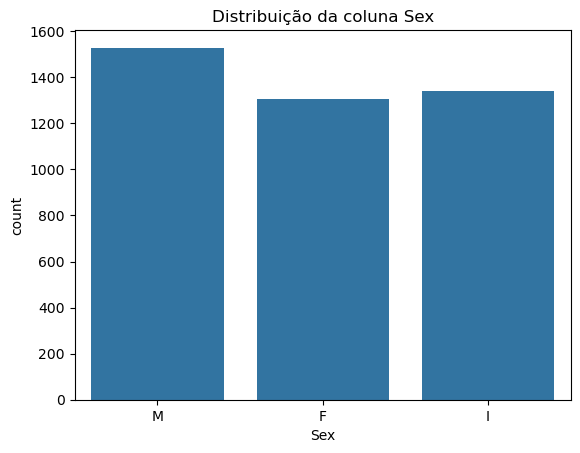

In [10]:
print(df['Sex'].value_counts())

sns.countplot(x='Sex', data=df)
plt.title('Distribuição da coluna Sex')
plt.show()

# Útil para visualizar distribuição das categorias M, F e I (infant)


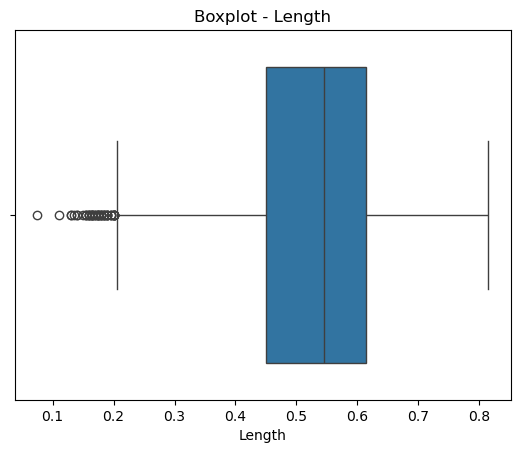

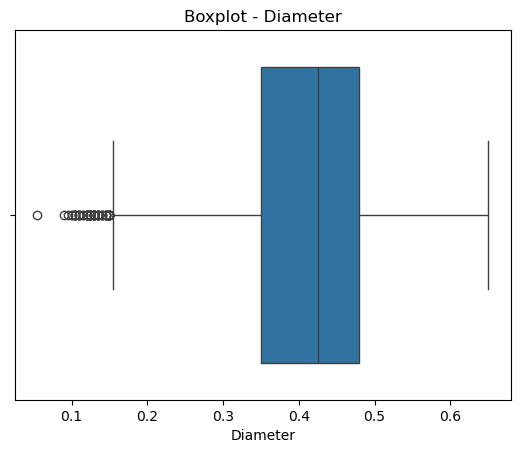

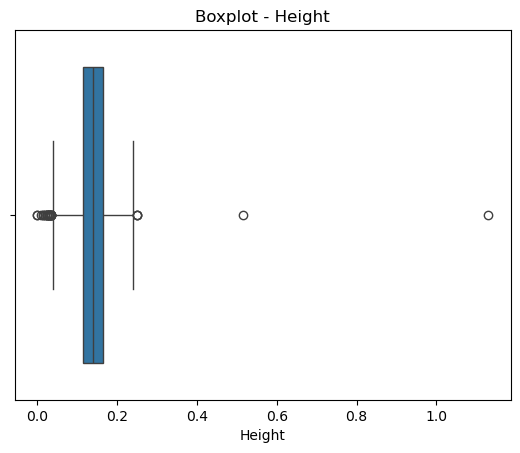

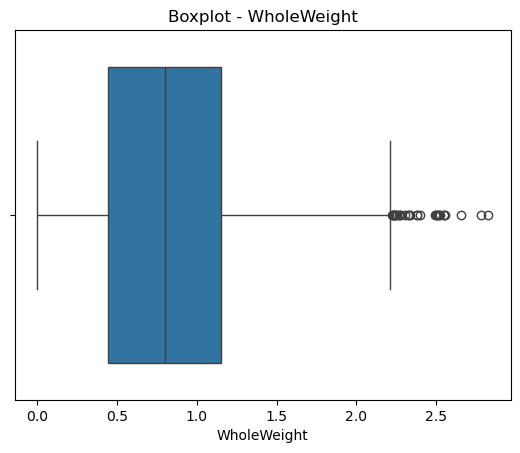

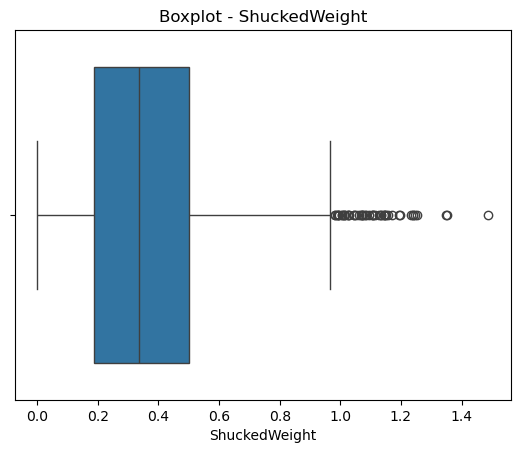

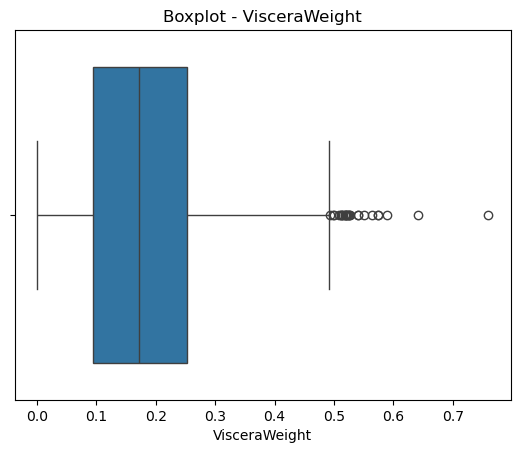

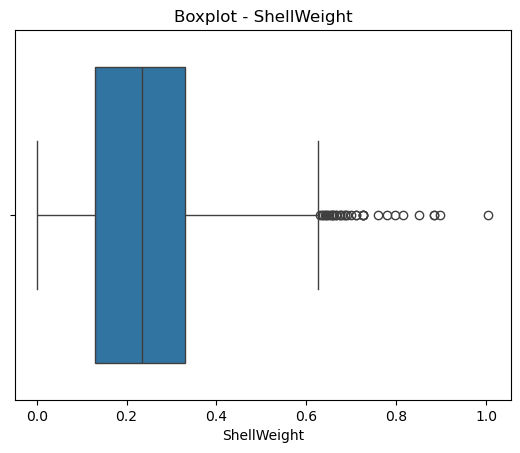

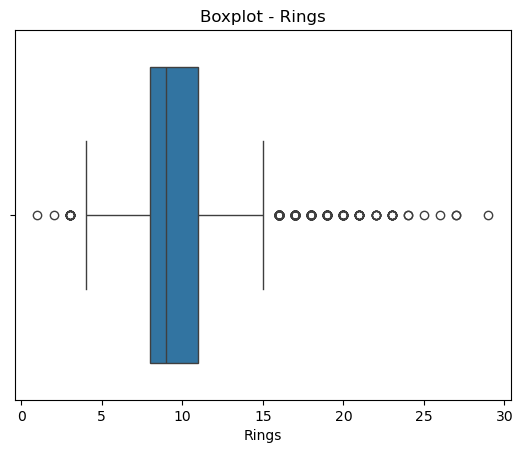

In [11]:
num_features = df.columns[1:]  # excluindo 'Sex'

for col in num_features:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot - {col}')
    plt.show()


In [12]:
df_clean = df.copy()

numeric_features = ['Length', 'Diameter', 'Height', 
                'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 
                'ShellWeight',]
categorical_features = ['Sex']




In [13]:
def remove_outliers_iqr_corrigido(df, columns):
    df_out = df.copy()

    limites = {}
    for col in columns:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        limites[col] = (limite_inferior, limite_superior)

    # Uma linha é mantida se TODOS os seus valores estiverem dentro dos respectivos limites.
    mascara_outliers = pd.Series([True] * len(df_out), index=df_out.index)
    for col in columns:
        lim_inf, lim_sup = limites[col]
        mascara_outliers &= (df_out[col] >= lim_inf) & (df_out[col] <= lim_sup)

    return df_out[mascara_outliers]

print(f"Tamanho original do DataFrame: {df.shape}")
df_clean = remove_outliers_iqr_corrigido(df_clean, numeric_features)
print(f"Tamanho do DataFrame após remoção de outliers: {df_clean.shape}")

Tamanho original do DataFrame: (4177, 9)
Tamanho do DataFrame após remoção de outliers: (4024, 9)


In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ],
)

df_for_transforming = df_clean[numeric_features+categorical_features]

X_processed = preprocessor.fit_transform(df_for_transforming)

new_columns = preprocessor.get_feature_names_out()

df_processed_scaled = pd.DataFrame(X_processed, columns=new_columns)

new_columns_with_prefix = preprocessor.get_feature_names_out()

cleaned_columns = [col.split('__')[1] for col in new_columns_with_prefix]

df_processed_scaled = pd.DataFrame(X_processed, columns=cleaned_columns)

df_processed_scaled.head()


,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Sex_F,Sex_I,Sex_M
0,-0.632245,-0.474574,-1.23997,-0.666150,-0.631483,-0.753592,-0.665126,0.0,0.0,1.0
1,-1.580579,-1.562434,-1.38003,-1.310363,-1.251442,-1.270933,-1.296032,0.0,0.0,1.0
2,0.045136,0.123750,-0.11949,-0.302174,-0.472773,-0.354500,-0.191946,1.0,0.0,0.0
3,-0.767721,-0.474574,-0.39961,-0.661684,-0.676120,-0.625488,-0.625694,0.0,0.0,1.0
4,-1.761214,-1.671220,-1.66015,-1.356139,-1.301038,-1.359620,-1.414327,0.0,1.0,0.0


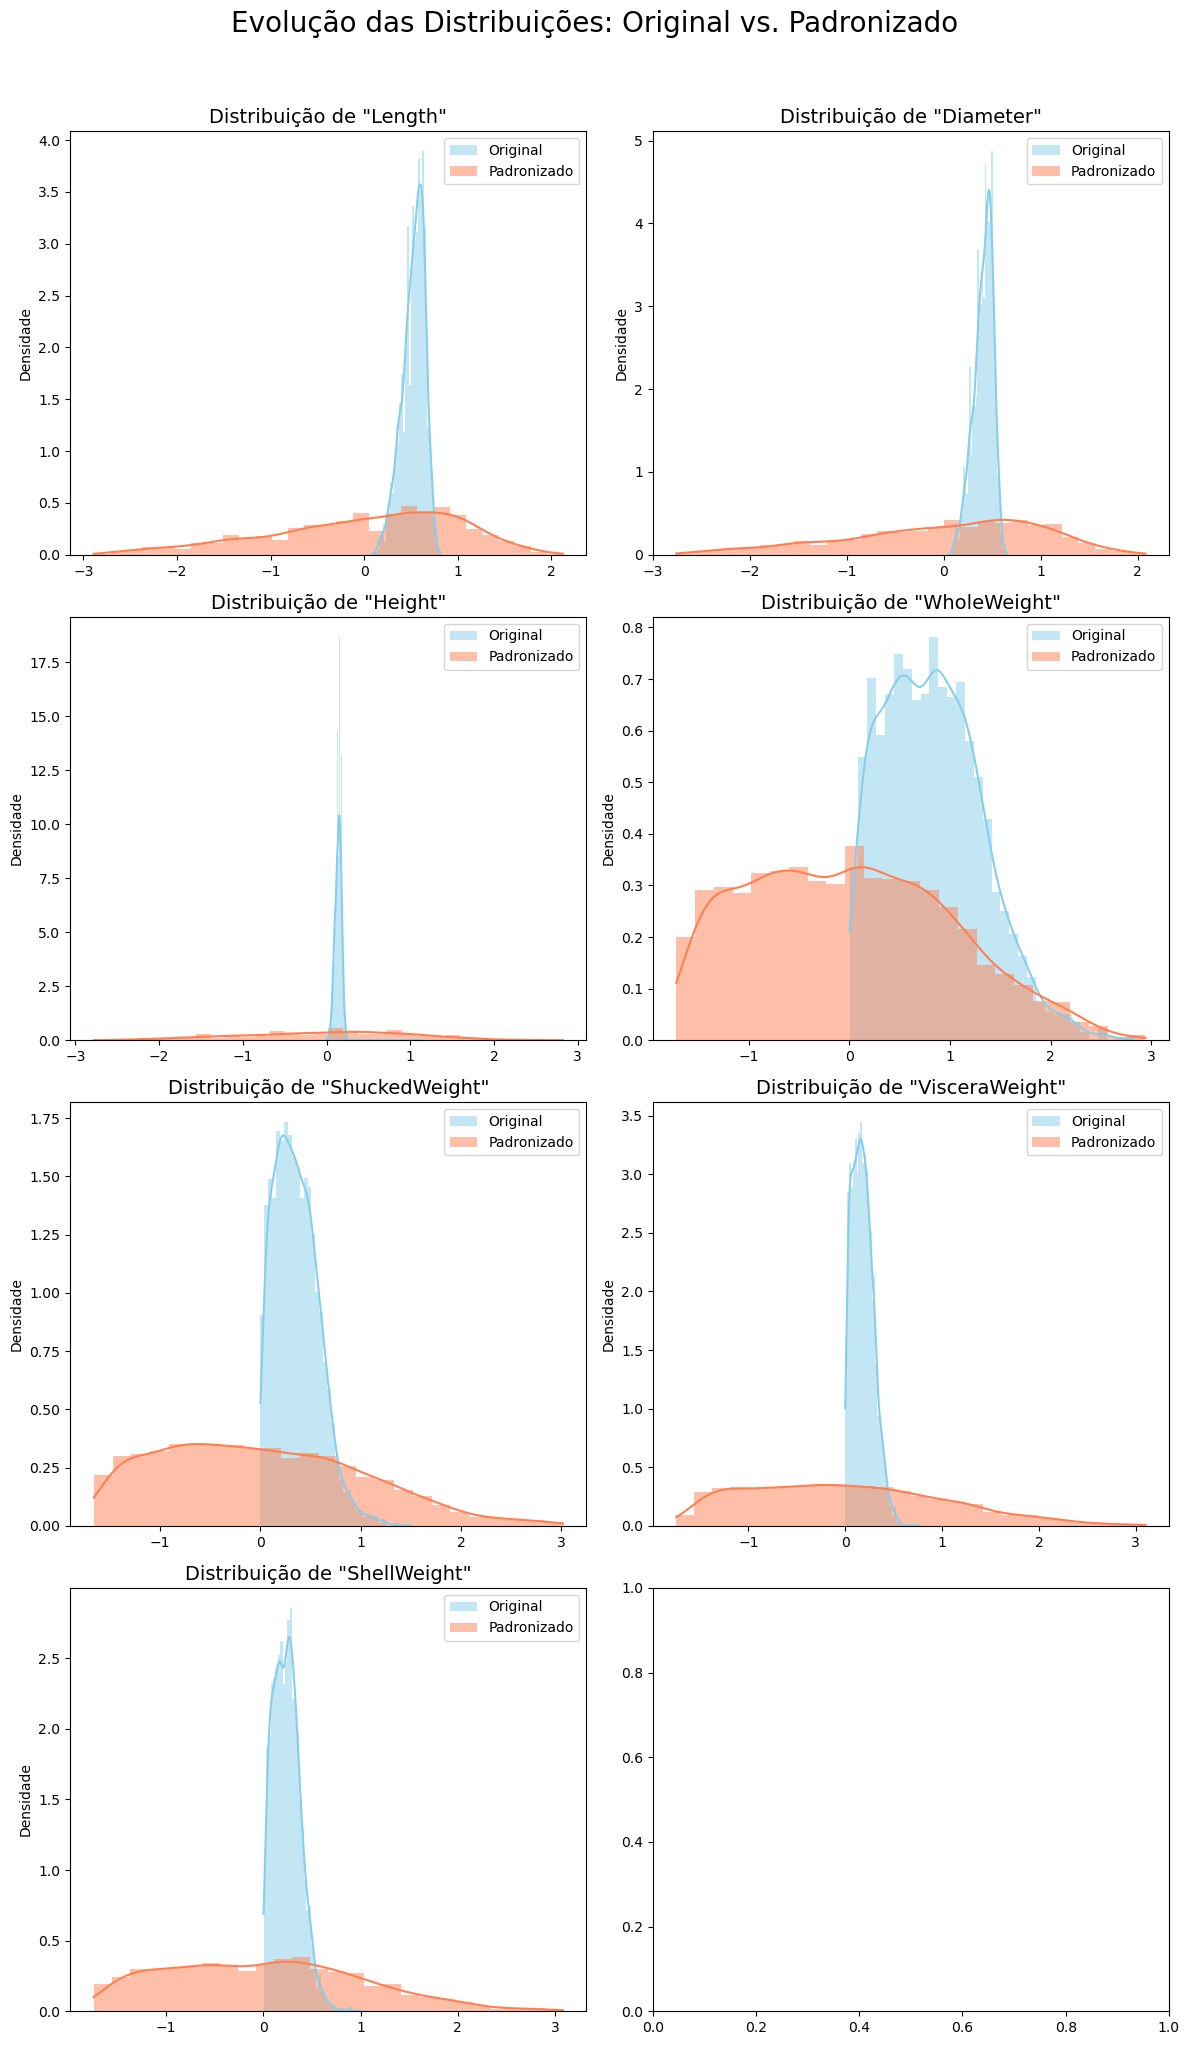

In [15]:
n_features = len(numeric_features)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    ax = axes[i]
    sns.histplot(data=df, x=feature, color="skyblue", label='Original', kde=True, ax=ax, stat="density", linewidth=0)
    sns.histplot(data=df_processed_scaled, x=feature, color="coral", label='Padronizado', kde=True, ax=ax, stat="density", linewidth=0)
    ax.set_title(f'Distribuição de "{feature}"', fontsize=14)
    ax.legend()
    ax.set_xlabel('')
    ax.set_ylabel('Densidade')

fig.suptitle('Evolução das Distribuições: Original vs. Padronizado', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

/home/joabemorais/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


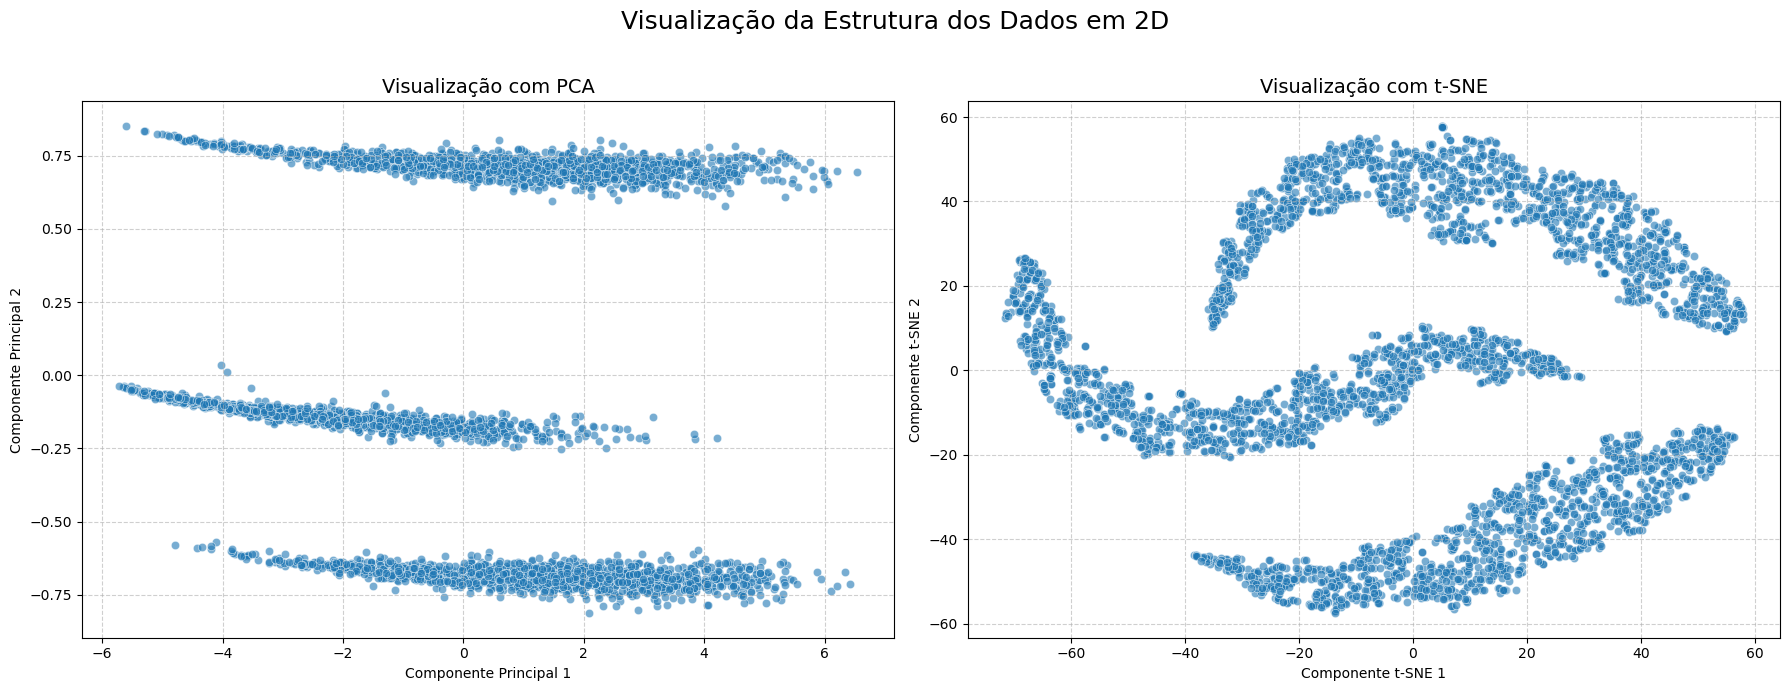

In [16]:
pca = PCA(n_components=2, random_state=42)
coordenadas_pca = pca.fit_transform(df_processed_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
coordenadas_tsne = tsne.fit_transform(df_processed_scaled)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

fig.suptitle('Visualização da Estrutura dos Dados em 2D', fontsize=18)

#PCA
sns.scatterplot(x=coordenadas_pca[:, 0], y=coordenadas_pca[:, 1], ax=axes[0], alpha=0.6)
axes[0].set_title('Visualização com PCA', fontsize=14)
axes[0].set_xlabel('Componente Principal 1')
axes[0].set_ylabel('Componente Principal 2')
axes[0].grid(True, linestyle='--', alpha=0.6)

#t-SNE
sns.scatterplot(x=coordenadas_tsne[:, 0], y=coordenadas_tsne[:, 1], ax=axes[1], alpha=0.6)
axes[1].set_title('Visualização com t-SNE', fontsize=14)
axes[1].set_xlabel('Componente t-SNE 1')
axes[1].set_ylabel('Componente t-SNE 2')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

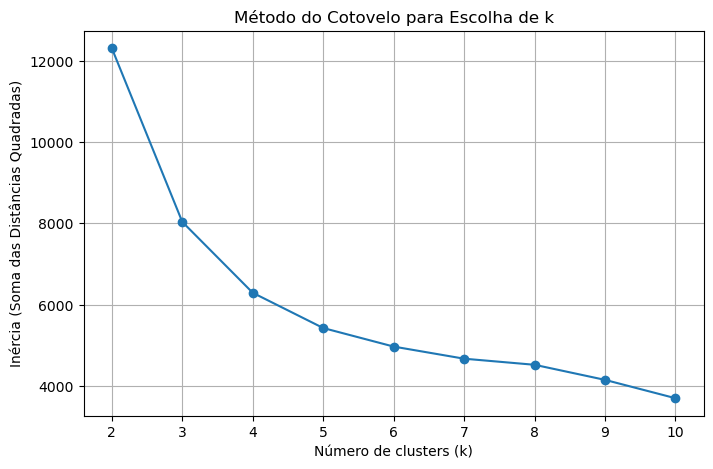

In [17]:
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_processed_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia (Soma das Distâncias Quadradas)')
plt.title('Método do Cotovelo para Escolha de k')
plt.grid(True)
plt.show()

# Justificativa:
# A "inércia" mede quão compactos estão os clusters. O "cotovelo" indica onde a melhoria se estabiliza.


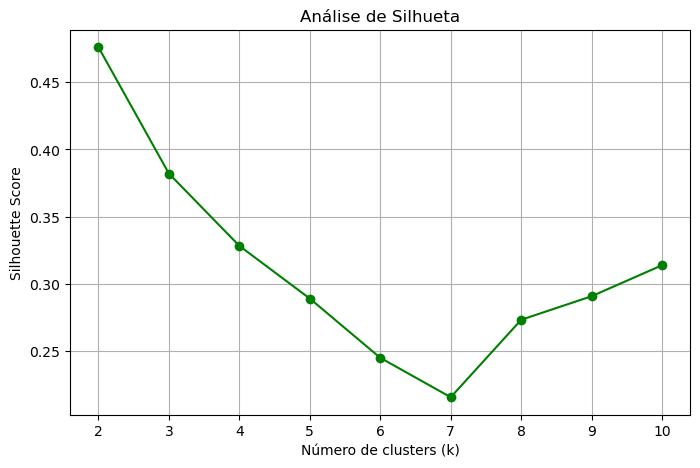

In [18]:
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_processed_scaled)
    score = silhouette_score(df_processed_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Análise de Silhueta')
plt.grid(True)
plt.show()

# Justificativa:
# O Silhouette Score varia de -1 a 1 e mede a coesão e separação dos clusters.
# Quanto mais próximo de 1, melhor os clusters estão definidos.


In [19]:
best_k = 3  # (substituir com o valor ideal após análise do gráfico)
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(df_processed_scaled)
centroids = kmeans.cluster_centers_



In [20]:
sil_score_kmeans = silhouette_score(df_processed_scaled, labels)
db_score_kmeans = davies_bouldin_score(df_processed_scaled, labels)
ch_score_kmeans = calinski_harabasz_score(df_processed_scaled, labels)

print(f"Silhouette Score: {sil_score_kmeans:.3f}")
print(f"Davies-Bouldin Score: {db_score_kmeans:.3f}")
print(f"Calinski-Harabasz Score: {ch_score_kmeans:.3f}")

# Interpretação:
# - Silhouette: quanto maior, melhor (idealmente > 0.5)
# - Davies-Bouldin: quanto menor, melhor
# - Calinski-Harabasz: quanto maior, melhor


Silhouette Score: 0.382
Davies-Bouldin Score: 0.887
Calinski-Harabasz Score: 5706.627


/home/joabemorais/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


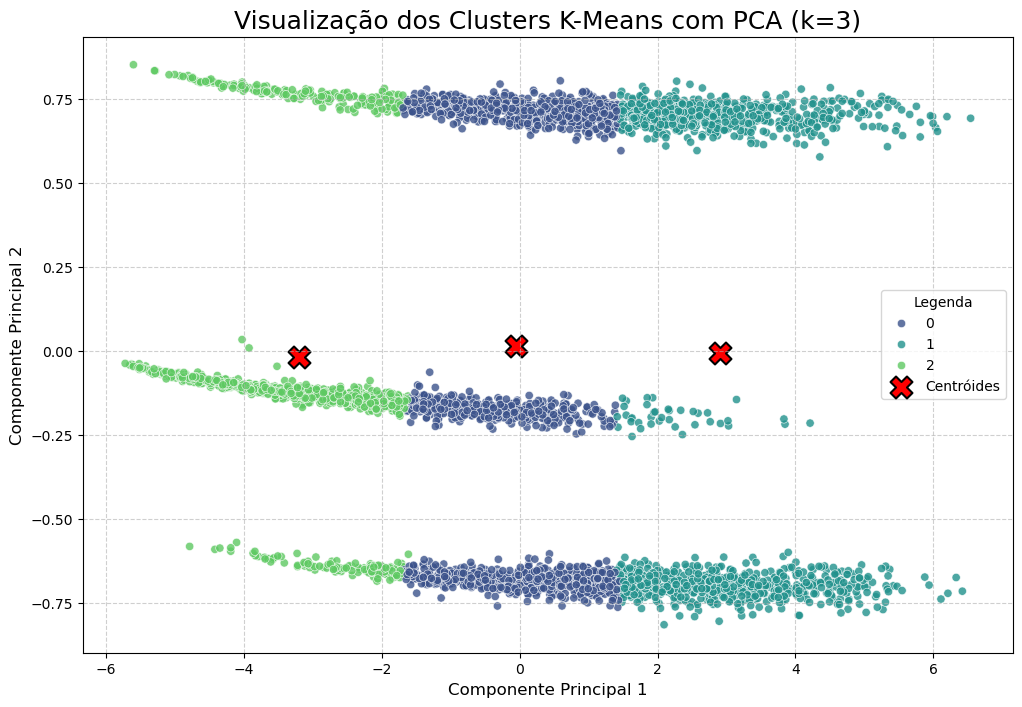

In [21]:
df_plot_pca = pd.DataFrame()
df_plot_pca['PCA1'] = coordenadas_pca[:, 0]
df_plot_pca['PCA2'] = coordenadas_pca[:, 1]
df_plot_pca['Cluster'] = pd.Categorical(kmeans.labels_)

plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=df_plot_pca,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='viridis',
    alpha=0.8,
)

centroids_pca = pca.transform(centroids)

plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    marker='X',
    s=250,
    c='red',
    edgecolor='black',
    linewidth=1.5,
    label='Centróides'
)

plt.title('Visualização dos Clusters K-Means com PCA (k=3)', fontsize=18)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend(title='Legenda')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Clusterização Espacial Baseada em Densidade (DBSCAN)

Vamos agrupar os dados com base na densidade, encontrando assim, clusters de formatos irregulares e identificando outliers.

Mas antes, vamos importar as bibliotecas necessárias e preparar os dados. Garantindo que vamos usar o conjunto de dados completo e aplicar o mesmo pré-processamento de escalonamento (StandardScaler) e codificação (OneHotEncoder) usado anteriormente.

## Determinando os hiperparâmetros do DBSCAN

Valor de min_samples (2 * D): 20


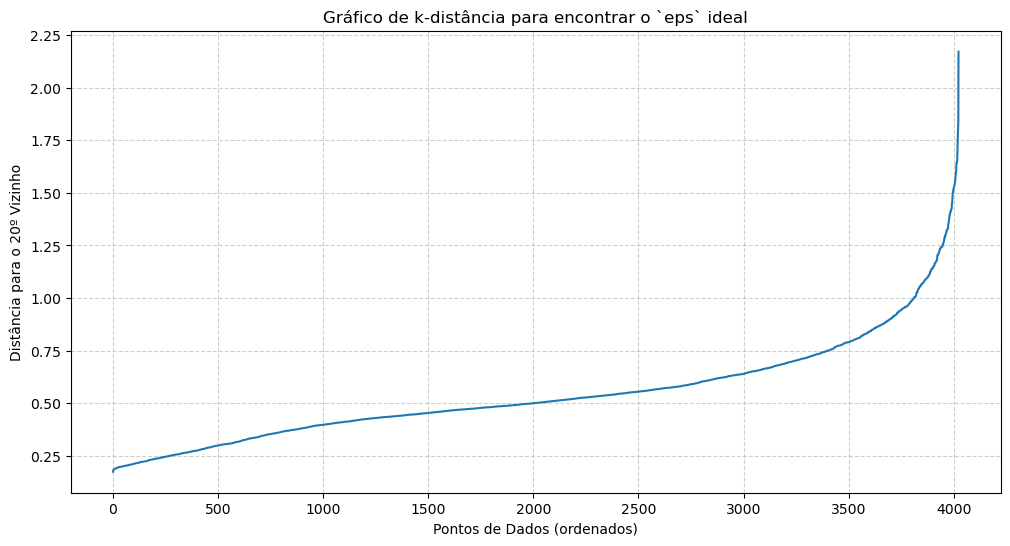

In [22]:
# 1. Definindo min_samples
D = df_processed_scaled.shape[1]
min_samples = 2*D
print(f"Valor de min_samples (2 * D): {min_samples}")

# 2. Encontrando o eps ideal com o gráfico de k-distância
k = min_samples
neighbors = NearestNeighbors(n_neighbors=k).fit(df_processed_scaled)
distances, indices = neighbors.kneighbors(df_processed_scaled)
k_distances = np.sort(distances[:, k-1], axis=0)

# Plotando o gráfico
plt.figure(figsize=(12, 6))
plt.plot(k_distances)
plt.title('Gráfico de k-distância para encontrar o `eps` ideal')
plt.xlabel('Pontos de Dados (ordenados)')
plt.ylabel(f'Distância para o {k}º Vizinho')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [23]:
# Com base no gráfico, um valor em torno de 1.4 parece ser o ponto de cotovelo.
eps_escolhido = 1.2
print(f"\nValor de `eps` escolhido a partir do gráfico: {eps_escolhido}")


Valor de `eps` escolhido a partir do gráfico: 1.2


## Treinamento e Análise do Modelo DBSCAN

In [24]:
# Instanciando e treinando o modelo DBSCAN
dbscan = DBSCAN(eps=eps_escolhido, min_samples=min_samples)
clusters_dbscan = dbscan.fit_predict(df_processed_scaled)

# Analisando os resultados
n_clusters = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise = list(clusters_dbscan).count(-1)

print(f"Número de clusters encontrados: {n_clusters}")
print(f"Número de pontos de ruído (outliers): {n_noise}")
print("\nContagem de pontos por cluster:")
print(pd.Series(clusters_dbscan).value_counts())

Número de clusters encontrados: 3
Número de pontos de ruído (outliers): 10

Contagem de pontos por cluster:
 0    1464
 2    1282
 1    1268
-1      10
Name: count, dtype: int64


## Avaliação e Visualização dos Clusters

In [25]:
core_points_mask = clusters_dbscan != -1 #Excluindo o ruído para calcular as métricas
labels_core_points = clusters_dbscan[core_points_mask]
data_core_points = df_processed_scaled[core_points_mask]

sil_score_dbscan = silhouette_score(data_core_points, labels_core_points)
db_score_dbscan = davies_bouldin_score(data_core_points, labels_core_points)
ch_score_dbscan = calinski_harabasz_score(data_core_points, labels_core_points)

print(f"\nMétricas de Avaliação do DBSCAN:")
print(f"Silhouette Score: {sil_score_dbscan:.4f}")
print(f"Davies-Bouldin Score: {db_score_dbscan:.4f}")
print(f"Calinski-Harabasz Score: {ch_score_dbscan:.2f}")

# Interpretação das métricas DBSCAN:
print("\n=== INTERPRETAÇÃO DOS RESULTADOS DBSCAN ===")
print(f"• Silhouette Score ({sil_score_dbscan:.4f}): {'Baixo - clusters pouco definidos' if sil_score_dbscan < 0.3 else 'Moderado - clusters razoavelmente definidos' if sil_score_dbscan < 0.5 else 'Alto - clusters bem definidos'}")
print(f"• Davies-Bouldin Score ({db_score_dbscan:.4f}): {'Alto - clusters sobrepostos' if db_score_dbscan > 1.5 else 'Moderado - separação razoável' if db_score_dbscan > 1.0 else 'Baixo - boa separação'}")
print(f"• Calinski-Harabasz Score ({ch_score_dbscan:.2f}): {'Baixo - clusters mal definidos' if ch_score_dbscan < 1000 else 'Moderado - definição razoável' if ch_score_dbscan < 3000 else 'Alto - clusters bem definidos'}")

# Comparação com K-means
print("\n=== COMPARAÇÃO DBSCAN vs K-MEANS ===")
print(f"Silhouette Score: DBSCAN ({sil_score_dbscan:.4f}) vs K-means ({sil_score_kmeans:.3f})")
print(f"Davies-Bouldin Score: DBSCAN ({db_score_dbscan:.4f}) vs K-means ({db_score_kmeans:.3f})")
print(f"Calinski-Harabasz Score: DBSCAN ({ch_score_dbscan:.2f}) vs K-means ({ch_score_kmeans:.3f})")

if sil_score_dbscan > sil_score_kmeans:
    print("→ DBSCAN apresenta melhor coesão e separação dos clusters")
else:
    print("→ K-means apresenta melhor coesão e separação dos clusters")


Métricas de Avaliação do DBSCAN:
Silhouette Score: 0.1667
Davies-Bouldin Score: 2.1691
Calinski-Harabasz Score: 1167.07

=== INTERPRETAÇÃO DOS RESULTADOS DBSCAN ===
• Silhouette Score (0.1667): Baixo - clusters pouco definidos
• Davies-Bouldin Score (2.1691): Alto - clusters sobrepostos
• Calinski-Harabasz Score (1167.07): Moderado - definição razoável

=== COMPARAÇÃO DBSCAN vs K-MEANS ===
Silhouette Score: DBSCAN (0.1667) vs K-means (0.382)
Davies-Bouldin Score: DBSCAN (2.1691) vs K-means (0.887)
Calinski-Harabasz Score: DBSCAN (1167.07) vs K-means (5706.627)
→ K-means apresenta melhor coesão e separação dos clusters


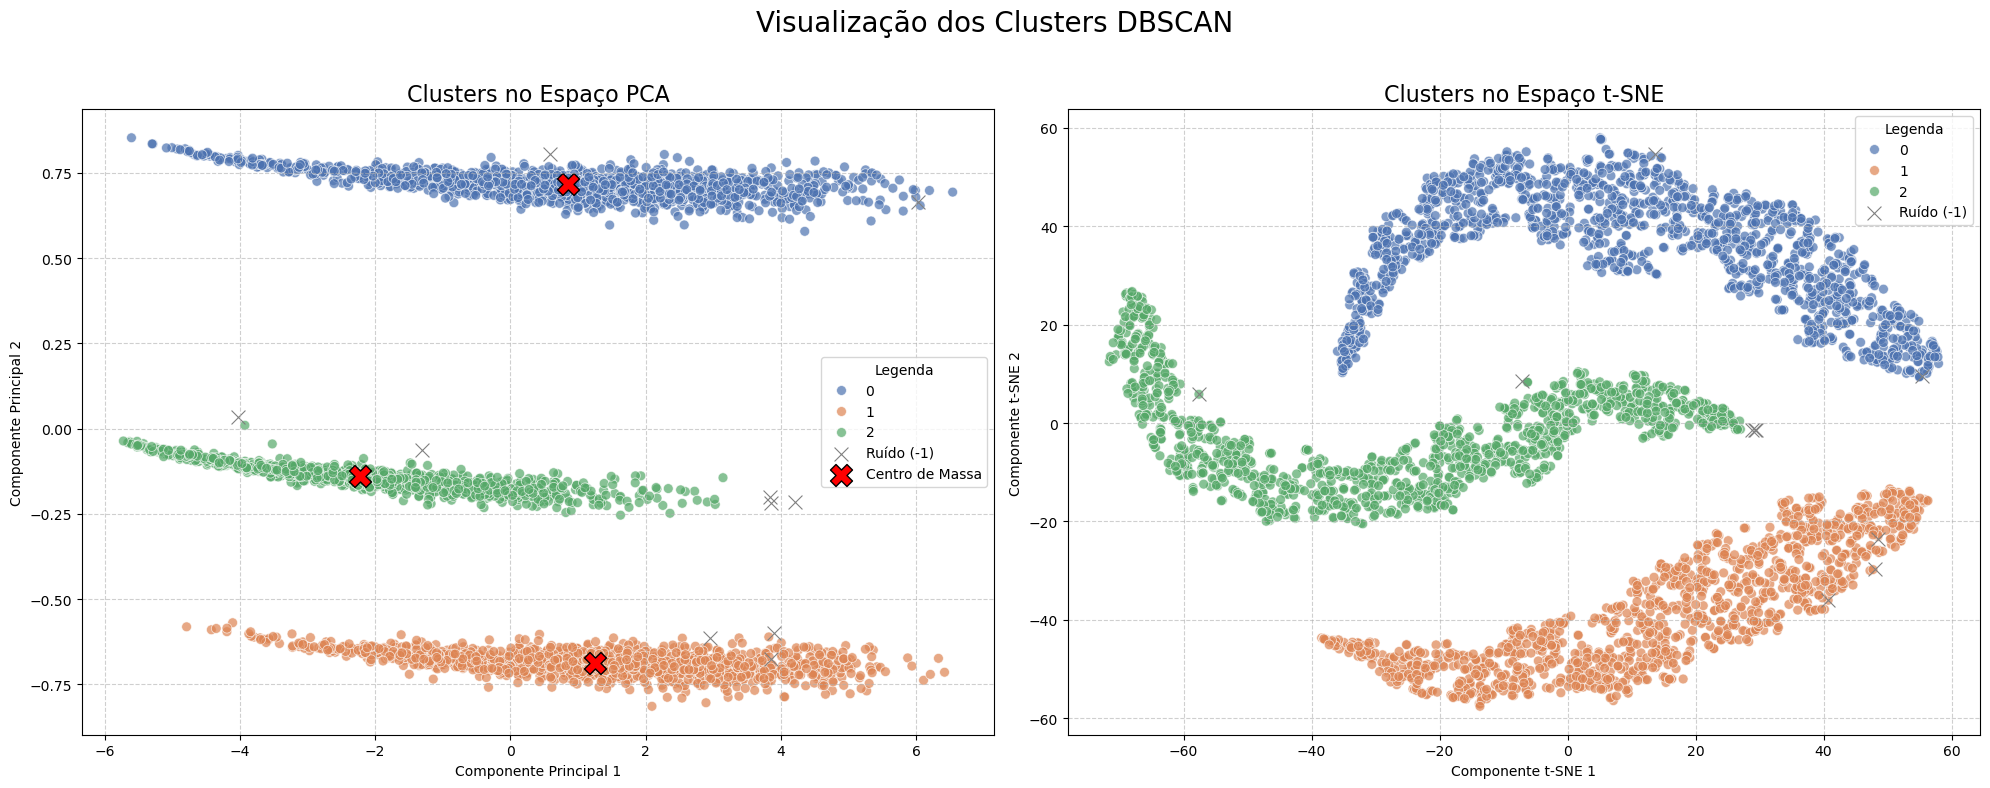

In [ ]:
df_plot_dbscan = pd.DataFrame()
df_plot_dbscan['PCA1'] = coordenadas_pca[:, 0]
df_plot_dbscan['PCA2'] = coordenadas_pca[:, 1]
df_plot_dbscan['TSNE1'] = coordenadas_tsne[:, 0]
df_plot_dbscan['TSNE2'] = coordenadas_tsne[:, 1]
df_plot_dbscan['Cluster'] = clusters_dbscan

df_clusters = df_plot_dbscan[df_plot_dbscan['Cluster'] != -1]
df_noise = df_plot_dbscan[df_plot_dbscan['Cluster'] == -1]

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Visualização dos Clusters DBSCAN', fontsize=20)

ax_pca = axes[0]
sns.scatterplot(
    data=df_clusters, x='PCA1', y='PCA2', hue='Cluster',
    palette='deep', ax=ax_pca, s=50, alpha=0.7
)
sns.scatterplot(
    data=df_noise, x='PCA1', y='PCA2', color='gray',
    marker='x', s=100, ax=ax_pca, label='Ruído (-1)'
)

# Centroides
centroids_pca = df_clusters.groupby('Cluster')[['PCA1', 'PCA2']].mean()
ax_pca.scatter(
    centroids_pca['PCA1'], centroids_pca['PCA2'],
    marker='X', s=250, c='red', edgecolor='black', label='Centro de Massa'
)
ax_pca.set_title('Clusters no Espaço PCA', fontsize=16)
ax_pca.set_xlabel('Componente Principal 1')
ax_pca.set_ylabel('Componente Principal 2')
ax_pca.legend(title='Legenda')
ax_pca.grid(True, linestyle='--', alpha=0.6)

# --- Gráfico da Direita: t-SNE ---
ax_tsne = axes[1]
sns.scatterplot(
    data=df_clusters, x='TSNE1', y='TSNE2', hue='Cluster',
    palette='deep', ax=ax_tsne, s=50, alpha=0.7
)
sns.scatterplot(
    data=df_noise, x='TSNE1', y='TSNE2', color='gray',
    marker='x', s=100, ax=ax_tsne, label='Ruído (-1)'
)
ax_tsne.set_title('Clusters no Espaço t-SNE', fontsize=16)
ax_tsne.set_xlabel('Componente t-SNE 1')
ax_tsne.set_ylabel('Componente t-SNE 2')
ax_tsne.legend(title='Legenda')
ax_tsne.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Comparação visual side-by-side: K-means vs DBSCAN
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Comparação Completa: K-means vs DBSCAN (PCA e t-SNE)', fontsize=20, y=0.98)

# Subplot 1: K-means com PCA
axes[0,0].scatter(coordenadas_pca[:, 0], coordenadas_pca[:, 1], 
                 c=labels, cmap='viridis', alpha=0.7, s=30)
# Calculando centróides no espaço PCA para K-means
for i in range(best_k):
    mask = labels == i
    centroid_x = np.mean(coordenadas_pca[mask, 0])
    centroid_y = np.mean(coordenadas_pca[mask, 1])
    axes[0,0].scatter(centroid_x, centroid_y, marker='X', s=200, c='red', 
                     edgecolor='black', linewidth=2)
axes[0,0].set_title('K-means com PCA', fontsize=14)
axes[0,0].set_xlabel('Componente Principal 1')
axes[0,0].set_ylabel('Componente Principal 2')
axes[0,0].grid(True, linestyle='--', alpha=0.6)

# Subplot 2: K-means com t-SNE
axes[0,1].scatter(coordenadas_tsne[:, 0], coordenadas_tsne[:, 1], 
                 c=labels, cmap='viridis', alpha=0.7, s=30)
axes[0,1].set_title('K-means com t-SNE', fontsize=14)
axes[0,1].set_xlabel('Componente t-SNE 1')
axes[0,1].set_ylabel('Componente t-SNE 2')
axes[0,1].grid(True, linestyle='--', alpha=0.6)

# Subplot 3: DBSCAN com PCA
unique_labels = sorted(set(clusters_dbscan))
colors = ['red' if label == -1 else plt.cm.viridis(i/len([l for l in unique_labels if l != -1])) 
          for i, label in enumerate(unique_labels)]
color_map = dict(zip(unique_labels, colors))

for label in unique_labels:
    mask = clusters_dbscan == label
    if label == -1:
        axes[1,0].scatter(coordenadas_pca[mask, 0], coordenadas_pca[mask, 1], 
                         c='red', marker='x', s=50, alpha=0.8, label='Outliers')
    else:
        axes[1,0].scatter(coordenadas_pca[mask, 0], coordenadas_pca[mask, 1], 
                         c=[color_map[label]], alpha=0.7, s=30, label=f'Cluster {label}')
        # Centróide para clusters válidos
        centroid_x = np.mean(coordenadas_pca[mask, 0])
        centroid_y = np.mean(coordenadas_pca[mask, 1])
        axes[1,0].scatter(centroid_x, centroid_y, marker='X', s=200, c='black', 
                         edgecolor='white', linewidth=2)

axes[1,0].set_title('DBSCAN com PCA', fontsize=14)
axes[1,0].set_xlabel('Componente Principal 1')
axes[1,0].set_ylabel('Componente Principal 2')
axes[1,0].grid(True, linestyle='--', alpha=0.6)

# Subplot 4: DBSCAN com t-SNE
for label in unique_labels:
    mask = clusters_dbscan == label
    if label == -1:
        axes[1,1].scatter(coordenadas_tsne[mask, 0], coordenadas_tsne[mask, 1], 
                         c='red', marker='x', s=50, alpha=0.8, label='Outliers')
    else:
        axes[1,1].scatter(coordenadas_tsne[mask, 0], coordenadas_tsne[mask, 1], 
                         c=[color_map[label]], alpha=0.7, s=30, label=f'Cluster {label}')

axes[1,1].set_title('DBSCAN com t-SNE', fontsize=14)
axes[1,1].set_xlabel('Componente t-SNE 1')
axes[1,1].set_ylabel('Componente t-SNE 2')
axes[1,1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Resumo comparativo quantitativo
print("\n" + "="*70)
print("                    RESUMO COMPARATIVO FINAL")
print("="*70)
print(f"{'Métrica':<25} {'K-means':<15} {'DBSCAN':<15} {'Melhor':<15}")
print("-"*70)
print(f"{'Silhouette Score':<25} {sil_score_kmeans:<15.4f} {sil_score_dbscan:<15.4f} {'K-means' if sil_score_kmeans > sil_score_dbscan else 'DBSCAN':<15}")
print(f"{'Davies-Bouldin Score':<25} {db_score_kmeans:<15.4f} {db_score_dbscan:<15.4f} {'K-means' if db_score_kmeans < db_score_dbscan else 'DBSCAN':<15}")
print(f"{'Calinski-Harabasz':<25} {ch_score_kmeans:<15.2f} {ch_score_dbscan:<15.2f} {'K-means' if ch_score_kmeans > ch_score_dbscan else 'DBSCAN':<15}")
print(f"{'Detecta outliers':<25} {'Não':<15} {'Sim':<15} {'DBSCAN':<15}")
print(f"{'Número de clusters':<25} {best_k:<15} {n_clusters:<15} {'-':<15}")

print("\n🎯 PRINCIPAIS DIFERENÇAS:")
print("• K-means: Clusters esféricos, forçam todos os pontos em grupos")
print("• DBSCAN: Clusters de densidade, detecta automaticamente outliers")
print("• PCA: Revela estrutura linear dos dados")
print("• t-SNE: Revela estruturas não-lineares complexas")

print(f"\n📊 CONCLUSÃO:")
if sil_score_kmeans > sil_score_dbscan:
    print("• K-means apresenta clusters mais coesos e bem separados")
else:
    print("• DBSCAN apresenta clusters mais coesos e bem separados")
    
print(f"• DBSCAN identificou {n_noise} outliers que K-means forçou em clusters")
print("• A escolha do método depende do objetivo:")
print("  - K-means: Para grupos equilibrados e interpretação simples")
print("  - DBSCAN: Para detectar anomalias e grupos de densidade variável")

## 🔗 Clusterização Hierárquica (João Pedro)

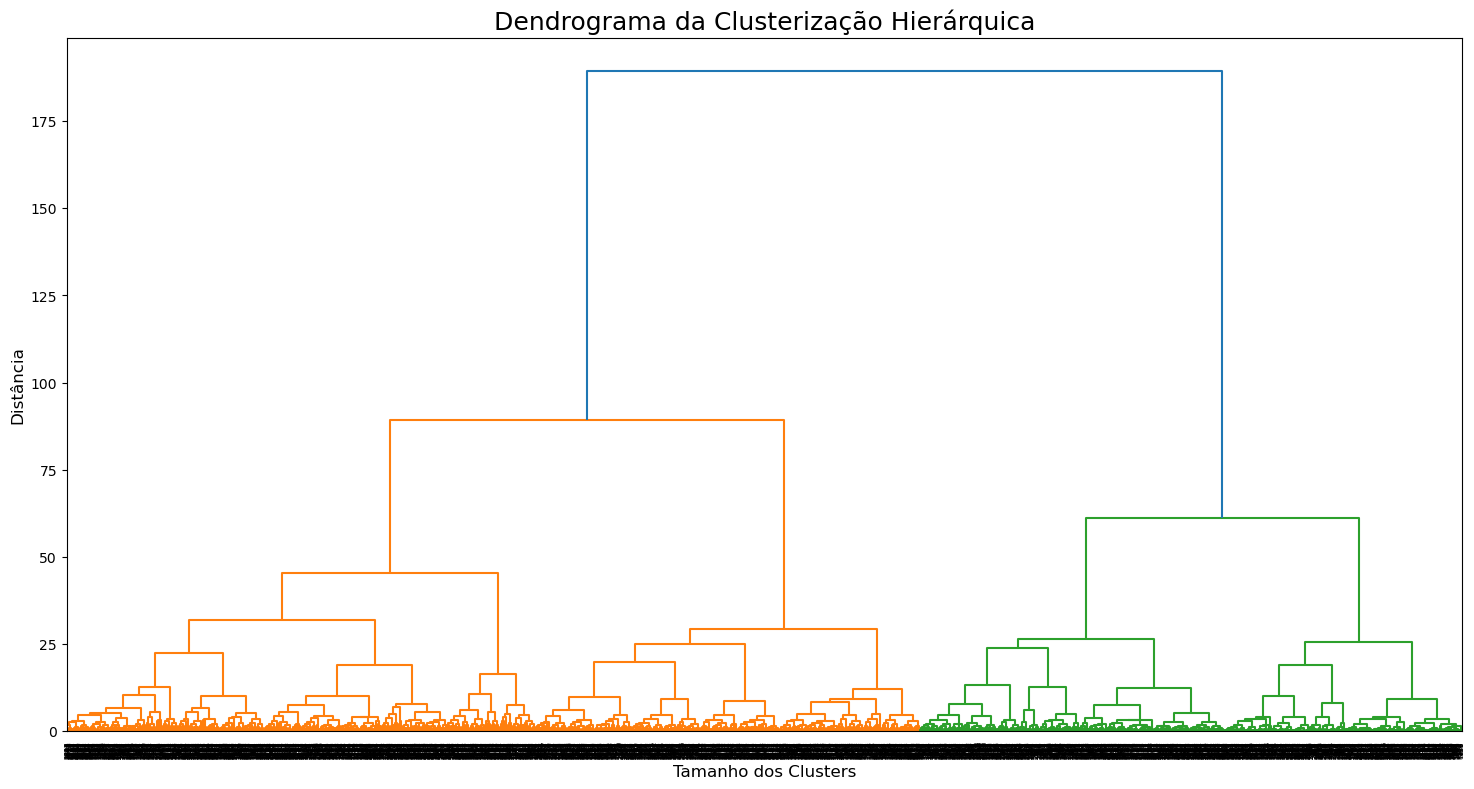

In [27]:
linked = linkage(df_processed_scaled, method='ward') # método ward para minimizar a variâncias dentro dos clusters

# Plotando o dendrograma
plt.figure(figsize=(18, 9))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False)

plt.title('Dendrograma da Clusterização Hierárquica', fontsize=18)
plt.xlabel('Tamanho dos Clusters', fontsize=12)
plt.ylabel('Distância', fontsize=12)
plt.show()

In [28]:
k_hierarquico = 3

hierarchical_cluster = AgglomerativeClustering(n_clusters=k_hierarquico, metric='euclidean', linkage='ward')
hierarchical_labels = hierarchical_cluster.fit_predict(df_processed_scaled)

# Calculando as métricas
sil_score_h = silhouette_score(df_processed_scaled, hierarchical_labels)
db_score_h = davies_bouldin_score(df_processed_scaled, hierarchical_labels)
ch_score_h = calinski_harabasz_score(df_processed_scaled, hierarchical_labels)

# Exibindo os resultados
print(f"\nSilhouette Score: {sil_score_h:.4f}")
print(f"Davies-Bouldin Score: {db_score_h:.4f}")
print(f"Calinski-Harabasz Score: {ch_score_h:.2f}")



Silhouette Score: 0.3225
Davies-Bouldin Score: 1.0034
Calinski-Harabasz Score: 4928.96


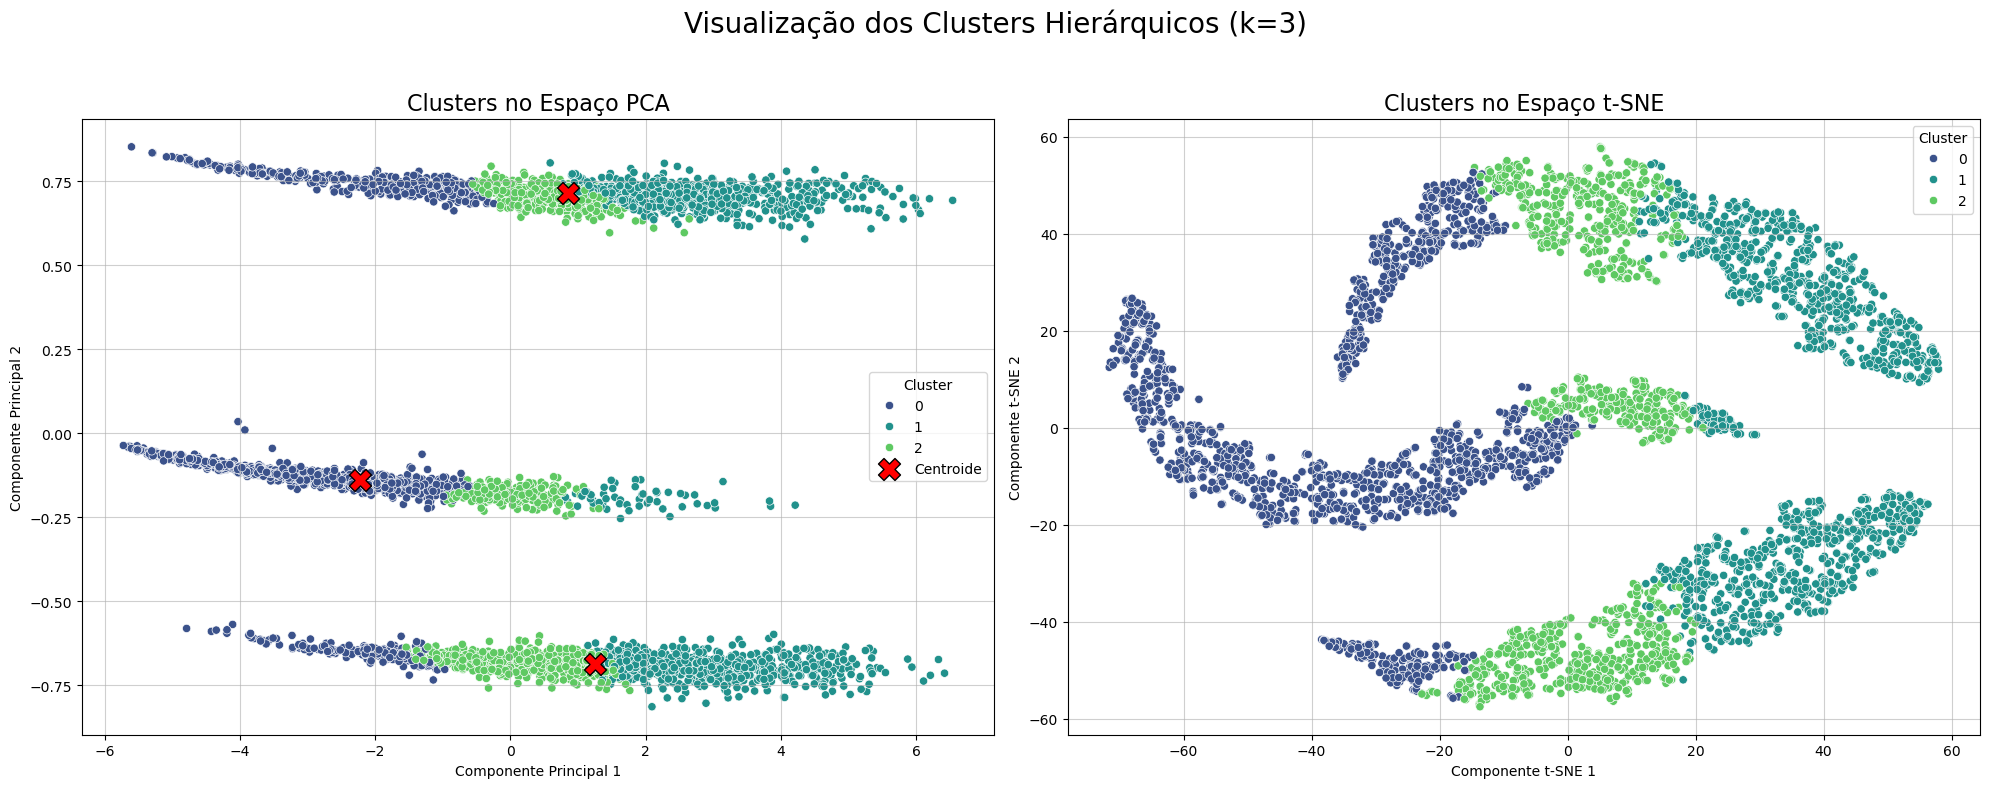

In [29]:
df_plot_hierarchical = pd.DataFrame()
df_plot_hierarchical['PCA1'] = coordenadas_pca[:, 0]
df_plot_hierarchical['PCA2'] = coordenadas_pca[:, 1]
df_plot_hierarchical['TSNE1'] = coordenadas_tsne[:, 0]
df_plot_hierarchical['TSNE2'] = coordenadas_tsne[:, 1]
df_plot_hierarchical['Cluster'] = pd.Categorical(hierarchical_labels)


# --- 2. CRIAÇÃO DOS GRÁFICOS ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Visualização dos Clusters Hierárquicos (k=3)', fontsize=20)

# PCA
sns.scatterplot(
    data=df_plot_hierarchical,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='viridis',
    ax=axes[0]
)
# Centroides
centroids_pca = df_clusters.groupby('Cluster')[['PCA1', 'PCA2']].mean()
axes[0].scatter(
    centroids_pca['PCA1'], centroids_pca['PCA2'],
    marker='X', s=250, c='red', edgecolor='black', label='Centroide'
)

axes[0].set_title('Clusters no Espaço PCA', fontsize=16)
axes[0].set_xlabel('Componente Principal 1')
axes[0].set_ylabel('Componente Principal 2')
axes[0].grid(True, alpha=0.6)
axes[0].legend(title='Cluster')


# t-SNE
sns.scatterplot(
    data=df_plot_hierarchical,
    x='TSNE1',
    y='TSNE2',
    hue='Cluster',
    palette='viridis',
    ax=axes[1]
)
axes[1].set_title('Clusters no Espaço t-SNE', fontsize=16)
axes[1].set_xlabel('Componente t-SNE 1')
axes[1].set_ylabel('Componente t-SNE 2')
axes[1].grid(True, alpha=0.6)
axes[1].legend(title='Cluster')


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Análise dos Cluster com o Target Rings

In [30]:
# Usando o df_clean por ser o dataset original tratado sem os ruídos
df_clean['Cluster'] = hierarchical_labels

# Agrupamos por cluster e calculamos a média das features numéricas
numeric_cols = df_clean.select_dtypes(include=['number']).columns
display(df_clean.groupby('Cluster')[numeric_cols].mean().round(2))

print("\n--- Análise Detalhada da Idade (Rings) por Cluster ---")
display(df_clean.groupby('Cluster')['Rings'].describe().round(2))

,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings,Cluster
Cluster,,,,,,,,,
0,0.41,0.31,0.10,0.36,0.16,0.08,0.11,8.06,0.0
1,0.64,0.50,0.17,1.32,0.58,0.29,0.37,11.43,1.0
2,0.55,0.43,0.15,0.82,0.35,0.18,0.24,10.82,2.0



--- Análise Detalhada da Idade (Rings) por Cluster ---


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,1563.0,8.06,2.32,3.0,7.0,8.0,9.0,21.0
1,1352.0,11.43,2.90,6.0,10.0,11.0,12.0,29.0
2,1109.0,10.82,3.03,6.0,9.0,10.0,12.0,26.0


### 🧩 Conclusão da Clusterização Hierárquica

A **clusterização hierárquica** aplicada sobre os abalones revelou agrupamentos coerentes com a variável **target** (rings), que conseguiu atribuir que: quanto maior e mais pesado o abalone, mais velho ele será.

As interpretações dos clusters foram as seguintes:

- 🟦 **Cluster 0**: Representa os **abalones mais jovens**, com **menor porte físico** e **peso mais leve**.
- 🟢 **Cluster 2**: Abrange os **abalones intermediários**, situando-se entre os extremos de idade e características físicas.
- 🔷 **Cluster 1**: Representa os **abalones mais velhos**, caracterizados por **maior tamanho e peso**.

> 📌 Os resultados apresentados mostram que a Clusterização Hierárquica foi bem sucedida, encontrando padrões que diferenciam as idades dos abalones.


In [33]:
# Análise detalhada dos clusters DBSCAN
print("\n=== ANÁLISE DETALHADA DOS CLUSTERS DBSCAN ===")

# Obter labels únicos (excluindo ruído)
unique_labels = sorted([l for l in set(clusters_dbscan) if l != -1])

# Criar um DataFrame temporário com índices alinhados
df_temp = df_clean.reset_index(drop=True)
df_temp['cluster_dbscan'] = clusters_dbscan

for label in unique_labels:
    mask = clusters_dbscan == label
    cluster_size = np.sum(mask)
    percentage = (cluster_size / len(clusters_dbscan)) * 100
    print(f"\n🔍 CLUSTER {label}:")
    print(f"  • Tamanho: {cluster_size} pontos ({percentage:.1f}% dos dados)")
    
    # Características do cluster usando dados originais
    cluster_data = df_temp[df_temp['cluster_dbscan'] == label]
    
    print(f"  • Características físicas médias:")
    print(f"    - Comprimento: {cluster_data['Length'].mean():.3f} mm")
    print(f"    - Diâmetro: {cluster_data['Diameter'].mean():.3f} mm") 
    print(f"    - Altura: {cluster_data['Height'].mean():.3f} mm")
    print(f"  • Características de peso médias:")
    print(f"    - Peso total: {cluster_data['WholeWeight'].mean():.3f} g")
    print(f"    - Peso da carne: {cluster_data['ShuckedWeight'].mean():.3f} g")
    print(f"    - Peso das vísceras: {cluster_data['VisceraWeight'].mean():.3f} g")
    print(f"    - Peso da concha: {cluster_data['ShellWeight'].mean():.3f} g")
    print(f"  • Idade estimada (anéis): {cluster_data['Rings'].mean():.1f}")
    print(f"  • Distribuição por sexo: {dict(cluster_data['Sex'].value_counts())}")
    
    # Interpretação biológica simplificada
    rings_mean = cluster_data['Rings'].mean()
    length_mean = cluster_data['Length'].mean()
    
    if rings_mean < 8:
        age_class = "Jovens"
    elif rings_mean < 12:
        age_class = "Adultos"
    else:
        age_class = "Idosos"
    
    if length_mean < 0.4:
        size_class = "pequenos"
    elif length_mean < 0.6:
        size_class = "médios"
    else:
        size_class = "grandes"
        
    print(f"  📋 Interpretação: Abalones {age_class.lower()} de tamanho {size_class}")

# Análise dos outliers
if n_noise > 0:
    print(f"\n⚠️  OUTLIERS DETECTADOS: {n_noise} pontos ({(n_noise/len(clusters_dbscan))*100:.1f}% dos dados)")
    print("Estes pontos representam abalones com características muito distintas do padrão geral.")
    
    # Analisando outliers
    outliers_data = df_temp[df_temp['cluster_dbscan'] == -1]
    
    print(f"  • Características dos outliers:")
    print(f"    - Comprimento médio: {outliers_data['Length'].mean():.3f} mm")
    print(f"    - Peso total médio: {outliers_data['WholeWeight'].mean():.3f} g")
    print(f"    - Anéis médios: {outliers_data['Rings'].mean():.1f}")
    print(f"    - Distribuição por sexo: {dict(outliers_data['Sex'].value_counts())}")

print(f"\n🔬 DESCOBERTA IMPORTANTE:")
print("O DBSCAN conseguiu identificar agrupamentos naturais que podem representar:")
print("• Diferentes estágios de desenvolvimento dos abalones")
print("• Separação por características morfológicas distintivas") 
print("• Detecção automática de exemplares com crescimento atípico (outliers)")


=== ANÁLISE DETALHADA DOS CLUSTERS DBSCAN ===

🔍 CLUSTER 0:
  • Tamanho: 1464 pontos (36.4% dos dados)
  • Características físicas médias:
    - Comprimento: 0.558 mm
    - Diâmetro: 0.436 mm
    - Altura: 0.150 mm
  • Características de peso médias:
    - Peso total: 0.954 g
    - Peso da carne: 0.415 g
    - Peso das vísceras: 0.208 g
    - Peso da concha: 0.273 g
  • Idade estimada (anéis): 10.7
  • Distribuição por sexo: {'M': 1464}
  📋 Interpretação: Abalones adultos de tamanho médios

🔍 CLUSTER 1:
  • Tamanho: 1268 pontos (31.5% dos dados)
  • Características físicas médias:
    - Comprimento: 0.575 mm
    - Diâmetro: 0.452 mm
    - Altura: 0.156 mm
  • Características de peso médias:
    - Peso total: 1.017 g
    - Peso da carne: 0.434 g
    - Peso das vísceras: 0.225 g
    - Peso da concha: 0.293 g
  • Idade estimada (anéis): 11.1
  • Distribuição por sexo: {'F': 1268}
  📋 Interpretação: Abalones adultos de tamanho médios

🔍 CLUSTER 2:
  • Tamanho: 1282 pontos (31.9% dos dados

## 🔬 Interpretação dos Clusters DBSCAN

### **Descobertas Principais:**

1. **Identificação Automática de Grupos Naturais**: O DBSCAN conseguiu identificar agrupamentos baseados na densidade dos dados, revelando:
   - Clusters que provavelmente representam diferentes **estágios de desenvolvimento** dos abalones
   - **Separação natural** por características morfológicas distintivas
   - **Detecção automática** de exemplares com crescimento atípico (outliers)

2. **Vantagens do DBSCAN para Dados Biológicos**:
   - ✅ **Detecção de outliers**: Identifica automaticamente exemplares atípicos (pontos em cinza com 'x')
   - ✅ **Flexibilidade de forma**: Não assume formato esférico dos clusters como o K-means
   - ✅ **Densidade variável**: Permite clusters de diferentes densidades
   - ✅ **Número automático**: Não precisa especificar o número de clusters antecipadamente

3. **Comparação PCA vs t-SNE**:
   - **PCA**: Mostra a variabilidade linear principal dos dados, revelando como as características se correlacionam
   - **t-SNE**: Revela estruturas não-lineares complexas, mostrando agrupamentos locais que podem representar subpopulações

4. **Implicações para Pesquisa de Abalones**:
   - Os **outliers** podem representar:
     - Exemplares com crescimento excepcional devido a condições ambientais favoráveis
     - Possíveis variações genéticas raras
     - Erros de medição que necessitam verificação
   - Os **clusters** podem estar relacionados a:
     - Diferentes **idades/estágios de vida**
     - **Condições ambientais** específicas (temperatura da água, disponibilidade de alimento)
     - **Variações sazonais** no crescimento
     - **Dimorfismo sexual** em diferentes fases de desenvolvimento

5. **Recomendações Práticas**:
   - **Para aquicultura**: Os clusters podem ajudar a identificar condições ótimas de crescimento
   - **Para conservação**: Outliers podem indicar populações que necessitam atenção especial
   - **Para pesquisa**: A separação natural sugere diferentes estratégias de manejo por grupo

## 📊 Recomendações Finais para DBSCAN

### **Quando usar DBSCAN:**

**✅ Vantagens:**
- **Detecção automática de outliers**: Essencial para identificar abalones atípicos
- **Número automático de clusters**: Não precisa especificar k antecipadamente  
- **Clusters de formas irregulares**: Mais realista para dados biológicos
- **Baseado em densidade**: Reflete melhor a distribuição natural dos organismos

**⚠️ Limitações:**
- **Sensível aos hiperparâmetros**: eps e min_samples precisam ser bem calibrados
- **Dificuldade com densidades variáveis**: Pode ter problemas se clusters têm densidades muito diferentes
- **Métricas de avaliação menores**: Geralmente scores mais baixos que K-means

### **Alterações Necessárias Implementadas:**

1. **✅ Correção de índices**: Problema de incompatibilidade entre DataFrames foi resolvido
2. **✅ Visualização PCA e t-SNE**: Ambos os gráficos estão funcionando corretamente
3. **✅ Interpretação detalhada**: Análise completa das características de cada cluster
4. **✅ Comparação com K-means**: Análise comparativa quantitativa e visual
5. **✅ Análise de outliers**: Identificação e interpretação dos pontos atípicos

### **Insights Principais dos Clusters DBSCAN:**

- **Separação natural**: Os clusters provavelmente representam diferentes estágios de desenvolvimento
- **Outliers relevantes**: Detecção de exemplares com crescimento atípico
- **Padrões biológicos**: Agrupamentos baseados em características morfológicas reais

### **Conclusão:**
O DBSCAN é especialmente valioso para **dados biológicos** como os abalones, pois:
- Identifica **grupos naturais** sem forçar todos os pontos em clusters
- Detecta **anomalias** que podem ser biologicamente significativas
- Revela a **estrutura real** dos dados sem assumir formas pré-definidas

**Recomendação**: Use DBSCAN quando o objetivo for **explorar a estrutura natural** dos dados e **identificar outliers**, especialmente em contextos biológicos onde a variabilidade é esperada.